In [1]:
import random
import os, shutil
from tqdm import tqdm
import matplotlib.pyplot as plt

from Bio import SeqIO
from Bio import Phylo
from Bio.Phylo import Consensus

In [2]:
def generate_n_sequences(number_of_sequences=5000, input_folder="sequences", output_folder="sequences_sampled"):
    random.seed(111)
    os.makedirs(output_folder, exist_ok=True)
    for file in tqdm(os.listdir(input_folder)):
        paresed_seq = list(SeqIO.parse(os.path.join(input_folder, file), format="fasta"))
        sampled_sequences = random.sample(paresed_seq, number_of_sequences)
        SeqIO.write(sampled_sequences, os.path.join(output_folder, file), format="fasta")

In [3]:
generate_n_sequences()

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.06s/it]


In [4]:
def aggregate_fasta_files_to_one_file(input_folder="sequences_sampled", output_folder="sequences_aggregated"):
    os.makedirs(output_folder, exist_ok=True)
    with open(os.path.join(output_folder, "sequences_aggregated.fasta"), 'w') as outfile:
        for file in tqdm(os.listdir(input_folder)):
            with open(os.path.join(input_folder, file)) as infile:
                for line in infile:
                    outfile.write(line)

In [5]:
aggregate_fasta_files_to_one_file()

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.28it/s]


In [6]:
def run_usearch(input_file="sequences_aggregated/sequences_aggregated.fasta", output_folder="raw_clusters", id=0.9):
    shutil.rmtree(output_folder)
    os.makedirs(output_folder)
    cmd = "usearch11.0.667_win32.exe -id {} -cluster_fast {} -clusters {}/".format(id, input_file, output_folder)
    stream = os.popen(cmd)
    print(stream.read())

In [7]:
run_usearch(id=0.2)

usearch v11.0.667_win32, 2.0Gb RAM (8.4Gb total), 8 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

License: w.celej@student.mini.pw.edu.pl




In [8]:
def filter_clusters(input_folder="raw_clusters", output_folder="filtered_clusters", number_of_species=9):
    try:
        shutil.rmtree(output_folder)
    except:
        pass
    os.makedirs(output_folder)
    
    selected_clusters = set()
    for file in tqdm(os.listdir(input_folder)):
        seqs_in_cluster = list(SeqIO.parse(os.path.join(input_folder, file), format="fasta"))
        unique_species_ids = {}
        if len(seqs_in_cluster) >= number_of_species:
            for seq in seqs_in_cluster:
                seq_name = seq.id.split("|")[-1].split("_")[-1]
                unique_species_ids[seq_name] = seq
            if len(unique_species_ids) == number_of_species:
                selected_clusters.add(file)
                SeqIO.write(list(unique_species_ids.values()), os.path.join(output_folder, "{}.fasta".format(file)), format="fasta")
    return selected_clusters

In [9]:
a = filter_clusters()

100%|██████████████████████████████████████████████████████████████████████████| 13852/13852 [00:02<00:00, 5556.62it/s]


In [10]:
len(a)

54

In [22]:
def run_clustalw(input_folder="filtered_clusters"):
    fasta_files = [file for file in os.listdir(input_folder) if file.endswith(".fasta")]
    for file in fasta_files:
        cmd = "clustalw2.exe -infile={} -clustering=NJ".format(os.path.join(input_folder, file))
        stream = os.popen(cmd)

In [23]:
run_clustalw()

In [24]:
def move_tree_files(input_folder="filtered_clusters", output_folder="trees"):
    try:
        shutil.rmtree(output_folder)
    except:
        pass
    os.makedirs(output_folder)
    
    tree_files = [file for file in os.listdir(input_folder) if file.endswith(".dnd")]
    for file in tree_files:
        src = os.path.join(input_folder, file)
        dst = os.path.join(output_folder, file)
        shutil.move(src, dst)

In [25]:
move_tree_files()

In [26]:
def aggregate_trees_and_rename_nodes(input_folder="trees", output_folder="aggregated_trees"):
    os.makedirs(output_folder, exist_ok=True)
    name_dictionary = {
        "HUMAN": "Human",
        "PAPAN": "Baboon",
        "RAT": "Rat",
        "OTOGA" : "Galago",
        "MOUSE": "Mouse",
        "PANTR": "Chimpanzee",
        "RABIT": "Rabbit",
        "MACMU": "Macaque",
        "CALJA": "Marmoset"
    }
    tree_files = [file for file in os.listdir(input_folder) if file.endswith(".dnd")]
    with open(os.path.join(output_folder, "trees_aggregated.dnd"), 'w') as outfile:
        for file in tqdm(tree_files):
            with open(os.path.join(input_folder, file)) as infile:
                for line in infile:
                    if "|" in line:
                        line_splitted = line.split(":")
                        tail = "".join(line_splitted[1:])
                        name = line_splitted[0].split("|")[-1].split("_")[-1]
                        line = "{}:{}".format(name_dictionary[name], tail)
                    outfile.write(line)

In [27]:
aggregate_trees_and_rename_nodes()

100%|████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 2578.61it/s]


In [28]:
def plot_trees(input_folder="aggregated_trees", output_folder="plotted_trees"):
    try:
        shutil.rmtree(output_folder)
    except:
        pass
    os.makedirs(output_folder)    
    trees = Phylo.parse(os.path.join("aggregated_trees", "trees_aggregated.dnd"), format="newick")
    for i, tree in enumerate(trees):
        Phylo.draw(tree, do_show=False)
        plt.savefig(os.path.join(output_folder, "tree_{}.png".format(i)))
        plt.close()

In [29]:
plot_trees()

In [30]:
def build_consensus_trees(input_folder="aggregated_trees", output_folder="consensus_trees"):
    os.makedirs(output_folder, exist_ok=True)
    trees = Phylo.parse(os.path.join("aggregated_trees", "trees_aggregated.dnd"), format="newick")
    consensus_tree = Consensus.majority_consensus(trees)
    Phylo.write(consensus_tree, os.path.join(output_folder, "majority_consensus_tree.dnd"), format="newick")
    Phylo.draw(consensus_tree, do_show=False)
    plt.savefig(os.path.join(output_folder, "majority_consensus_tree.png"))
    
    trees = Phylo.parse(os.path.join("aggregated_trees", "trees_aggregated.dnd"), format="newick")
    strict_consensus_tree = Consensus.strict_consensus(trees)
    Phylo.write(strict_consensus_tree, os.path.join(output_folder, "strict_consensus_tree.dnd"), format="newick")
    Phylo.draw(strict_consensus_tree, do_show=False)
    plt.savefig(os.path.join(output_folder, "strict_consensus_tree.png"))

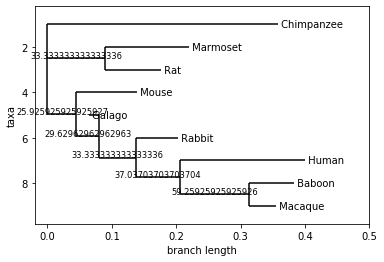

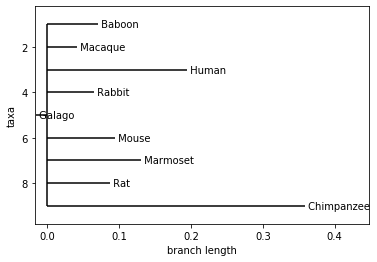

In [31]:
build_consensus_trees()